# Dispersion Analysis: Fornberg vs. DRP Stencils

In [1]:
import numpy as np
import scipy as sp
import sympy as sym
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from functools import partial
from matplotlib import patheffects
from numpy import linalg as la
import segyio
import sys
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import RectBivariateSpline

In [2]:
from devito import Grid, Function, TimeFunction, SparseTimeFunction, Eq, Operator, solve

In [3]:
normtype  = np.inf

## 0. Velocity Model

(3601, 2801)

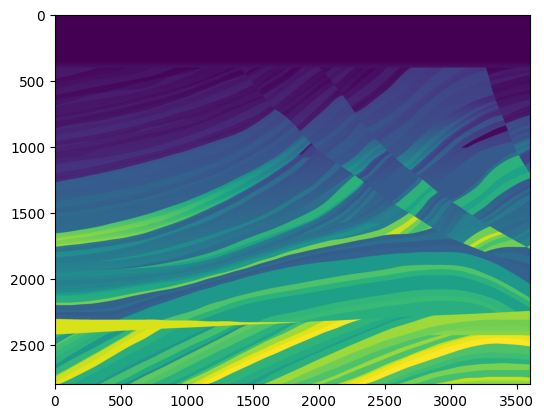

In [8]:
with segyio.open('velmodels/marmousi.segy') as segyfile:
    vvel = segyio.tools.cube(segyfile)[0,:,:]
vvel = vvel[5000:-5000,:]
hx       = 10
hy       = 10
plt.imshow(np.transpose(vvel))
vvel.shape

In [9]:
np.amax(vvel)

np.float32(4700.0)

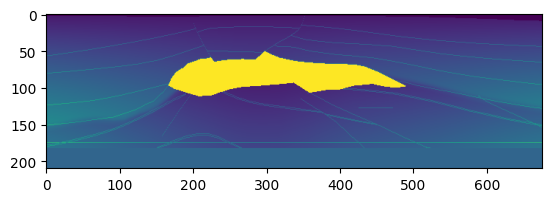

In [10]:
vvel = np.load("velmodels/salt.npy")
plt.imshow(np.transpose(vvel))
hx       = 10
hy       = 15

In [11]:
vvel.shape

(676, 210)

In [7]:
np.amax(vvel)

np.float32(4.4820004)

## 1. Problem Setup

In [7]:
def ricker(t, f):
    
    val1 = 1-2*((np.pi*f)*(t-1/f))**2
    val2 = -((np.pi*f)**2*(t-1/f)**2)
    val3 = val1*np.exp(val2)

    return val3

In [8]:
# Nsamples = 1000
# f = 0.02
# t = np.linspace(0, 1000, Nsamples + 1)
# rick = ricker(t, f=f)
# plt.plot(t,rick)

In [9]:
f0       = 0.02
extentx  = hx*vvel.shape[0]
extenty  = hy*vvel.shape[1]
npointsx = vvel.shape[0]
npointsy = vvel.shape[1]
t1       = 1200
vmax     = np.amax(vvel)

In [10]:
def critical_dt(weights,h,vmax):
    
    a = h*np.sqrt(2/np.sum([np.abs(a) for a in weights]))/vmax
    
    return float(a)

In [11]:
def critical_h(weights,dt,vmax):

    a = float(np.sqrt(2/np.sum([np.abs(a) for a in weights]))/(vmax*dt))
    b = 1/a
    
    return b

In [12]:
def acoustic(weightsx,weightsy,hx,hy,dt,vmodel,f,extentx,extenty,t1,factor=1):

    origin = (0., 0.)
    grid_extent = (extentx, extenty)
    snx = int(np.ceil((grid_extent[0] - origin[0])/hx))
    sny = int(np.ceil((grid_extent[1] - origin[1])/hy))
    shape = (snx, sny)
    
    t0 = 0
    tn = int(np.ceil((t1 - t0)/dt))

    vmax = np.amax(vmodel)
    
    r = vmax*dt/min(hx,hy)

    weightsx = np.concatenate([weightsx[::-1], weightsx[1:]])
    weightsy = np.concatenate([weightsy[::-1], weightsy[1:]])
    space_order = len(weightsx) - 1

    sx = grid_extent[0]/2 - origin[0]
    sy = 2*hy

    grid = Grid(shape=shape, extent=grid_extent)
    x, y = grid.dimensions

    velocity = Function(name="velocity", grid=grid, space_order=space_order)
    
    if(factor!=1):

        xoriginal        = np.linspace(0, extentx, vmodel.shape[0])
        yoriginal        = np.linspace(0, extenty, vmodel.shape[1])
        interp_spline    = RectBivariateSpline(xoriginal, yoriginal, vmodel)
        xx               = np.linspace(0, extentx, snx)
        yy               = np.linspace(0, extenty, sny)        
        vvelinterp       = interp_spline(xx, yy)
        velocity.data[:] = vvelinterp[:]

    else:

        velocity.data[:] = vmodel[:]

    
    t = np.linspace(t0, t1, tn)
    source = SparseTimeFunction(
        name="ricker",
        npoint=1,
        coordinates=[(sx, sy)],
        nt=tn,
        grid=grid,
        time_order=2,
        space_order=space_order
    )
    source.data[:, 0] = ricker(t,f=f)

    nrecv = vmodel.shape[0]
    rx = np.linspace(origin[0], grid_extent[0], nrecv)
    ry = 2*factor*hy*np.ones(nrecv)
    
    receiver = SparseTimeFunction(
        name="recv",
        npoint=nrecv,
        coordinates=np.array([rx, ry]).T,
        nt=tn,
        grid=grid
    )

    u = TimeFunction(name="u", grid=grid, time_order=2, space_order=space_order)

    pde = (1/velocity**2)*u.dt2 - u.dx2(weights=weightsx) - u.dy2(weights=weightsy)

    stencil = Eq(u.forward, solve(pde, u.forward))
    
    src_term = source.inject(field=u.forward, expr=source*factor*factor*velocity*velocity*dt*dt)
    recv_term = receiver.interpolate(expr=u.forward)
    op = Operator([stencil] + src_term + recv_term, subs=grid.spacing_map)
    op(time=tn - 1, dt=dt)
    
    return u.data[-1], receiver.data, r

In [13]:
M = 4
x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
N = 2
weightsteste  = sym.finite_diff_weights(N, x, 0)
fornbergteste = np.array(weightsteste[-1][-1][::2], dtype=np.float64)

In [14]:
dtinitial = critical_dt(fornbergteste,hx,vmax)
dtinitial

0.0013917267732610037

In [ ]:
uteste,datateste,rteste = acoustic(fornbergteste,fornbergteste,hx,hy,dtinitial,vvel,f0,extentx,extenty,t1)

In [ ]:
plt.imshow(np.transpose(uteste))

In [ ]:
plt.imshow(datateste)

In [ ]:
h = min(hx,hy)
dtnew1 = critical_dt(fornbergteste,h/5,vmax)
dtnew1

In [ ]:
dtnew = 0.2

In [ ]:
M = 10
x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
N = 2
weightsref  = sym.finite_diff_weights(N, x, 0)
fornbergref = np.array(weightsref[-1][-1][::2], dtype=np.float64)

In [ ]:
factor = 2
uref,dataref,rref = acoustic(fornbergref,fornbergref,hx/factor,hy/factor,dtnew/factor,vvel,f0,extentx,extenty,t1,factor=factor)

In [ ]:
plt.imshow(np.transpose(uref))

In [ ]:
plt.imshow(dataref)

In [ ]:
def critical_cfl(weights,h,dt,vmax):

    limit  = np.sqrt(2/np.sum([np.abs(a) for a in weights]))
    rvalue = (dt*vmax)/h

    print('Limit Value: %f'%limit)
    print('RVALUE: %f'%rvalue)
    
    if(limit>rvalue): 
        
        print('Stable Choice of weights,h,dt and vel!')
        print('')

    else:

        print('WARNING!"')
        print('Unstable Choice of weights, h,dt and vel!')
        print('')
        
    return

In [ ]:
mvalues  = [1,2,3,4,5,6,7,8,9,10]
nmavlues = len(mvalues)

## 2. Fornberg

In [ ]:
luf   = []
lrecf = []
lrf   = []

for k1 in range(0,nmavlues):

    M = k1 + 1
    x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
    N = 2
    weights     = sym.finite_diff_weights(N, x, 0)
    fornberg    = np.array(weights[-1][-1][::2], dtype=np.float64)
    uf,dataf,rf = acoustic(fornberg,fornberg,hx,hy,dtnew,vvel,f0,extentx,extenty,t1)

    luf.append(uf)
    lrecf.append(dataf)
    lrf.append(rf)
    critical_cfl(fornberg,h,dtnew,vmax)

Operator `Kernel` ran in 0.01 s


In [ ]:
luref    = []
lrecref  = []

for k0 in range(0,1):

    uloc    = luf[k0]
    ratio   = int((uref.shape[0]-1)/(uloc.shape[0]-1))
    urefloc = np.zeros((uloc.shape[0],uloc.shape[1]))
    conty   = 0
    
    for k1 in range(0,uloc.shape[1]):

        contx = 0
        
        for k2 in range(0,uloc.shape[0]):

            urefloc[k2,k1] = uref[contx,conty]
            
            contx = contx + ratio

        conty = conty + ratio

    luref.append(urefloc)

In [ ]:
for k0 in range(0,1):

    recloc    = lrecf[k0]
    ratio     = int(dataref.shape[0]/recloc.shape[0])
    recrefloc = np.zeros((recloc.shape[0],recloc.shape[1]))
    cont      = 0
    
    for k1 in range(0,recloc.shape[0]):

        contx            = 0
        recrefloc[k1,:]  = dataref[cont,:]
        cont             = cont + ratio
        
    lrecref.append(recrefloc)

In [ ]:
lnormuf   = []
lnormrecf = []

for k0 in range(0,nmavlues):
    
    difu   = luref[0] - luf[k0]
    lnormu = la.norm(difu,normtype)/la.norm(luref[0],normtype)

    difrec   = lrecref[0] - lrecf[k0]
    lnormrec = la.norm(difrec,normtype)/la.norm(lrecref[0],normtype)

    ctedt = np.sqrt(factor/1)
    ctedx = factor/1
    cte   = ctedt*ctedx
    
    lnormuf.append(cte*lnormu)
    lnormrecf.append(cte*lnormrec)

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(mvalues,lnormuf,label='Fornberg')
plt.grid()
plt.legend()
plt.title('Erro for M - Fornberg - Displacement')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.show()

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(mvalues,lnormrecf,label='Fornberg')
plt.grid()
plt.legend()
plt.title('Erro for M - Fornberg - Receivers')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.show()

## 3. DPRS - Method 1

In [ ]:
def objective(a):
    x = np.linspace(0, np.pi/2, 201)
    m = np.arange(1, len(a) + 1)
    y = x**2 + a[0] + 2*np.sum([a_ * np.cos(m_*x) for a_, m_ in zip(a[1:], m)], axis=0)
    return sp.integrate.trapezoid(y**2, x=x)

In [ ]:
ludrp1   = []
lrecdrp1 = []
lrdrp1   = []

for k1 in range(0,nmavlues):

    M = k1+1
    x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
    N = 2
    weights     = sym.finite_diff_weights(N, x, 0)
    fornberg    = np.array(weights[-1][-1][::2], dtype=np.float64)
    
    initial_guess = fornberg
    
    constraints = [{
        'type': 'eq',
        'fun': lambda x: x[0] + 2*np.sum(x[1:])
    }]
    constraints += [{
        'type': 'eq',
        'fun': lambda x: np.sum([xi*m**2 for m, xi in enumerate(x)]) - 1
    }]
    constraints += [{
        'type': 'eq',
        'fun': lambda x: np.sum([xi*m**(2*jj) for m, xi in enumerate(x)])
    } for jj in range(2, (len(initial_guess) + 1)//2)]
    
    opt1 = sp.optimize.minimize(objective, initial_guess, method='SLSQP', constraints=constraints, options=dict(ftol=1e-15, maxiter=500))
    drp_stencil1 = opt1.x

    uf,dataf,rf = acoustic(drp_stencil1,drp_stencil1,hx,hy,dtnew,vvel,f0,extentx,extenty,t1)

    ludrp1.append(uf)
    lrecdrp1.append(dataf)
    lrdrp1.append(rf)
    critical_cfl(drp_stencil1,h,dtnew,vmax)

In [ ]:
lnormudrp1   = []
lnormrecdrp1 = []

for k0 in range(0,nmavlues):
    
    difu   = luref[0] - ludrp1[k0]
    lnormu = la.norm(difu,normtype)/la.norm(luref[0],normtype)

    difrec   = lrecref[0] - lrecdrp1[k0]
    lnormrec = la.norm(difrec,normtype)/la.norm(lrecref[0],normtype)
    
    ctedt = np.sqrt(factor/1)
    ctedx = factor/1
    cte   = ctedt*ctedx
    
    lnormudrp1.append(cte*lnormu)
    lnormrecdrp1.append(cte*lnormrec)

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(mvalues,lnormudrp1,label='DRP1')
plt.grid()
plt.legend()
plt.title('Erro for M - DRP1 - Displacement')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.show()

## 4.DRPS - Method 2

In [ ]:
def dispersion_difference(weights,h,dt,v,k,alpha):
    if k == 0:
        diff = 0
    else:
        m = len(weights)
        cosines = np.array([
            np.cos(m*k*h*np.cos(alpha)) + np.cos(m*k*h*np.sin(alpha)) - 2
            for m in range(1, m)
        ])
        total = np.sum(np.array(weights)[1:]*cosines)
        theta = 1 + (v**2)*(dt**2)*total/(h**2)
        diff = np.abs(np.acos(theta)/(k*dt) - v)
    return diff

In [ ]:
def objective2(a, h, dt, fmax=100, vmin=np.amin(vvel), vmax=np.amax(vvel), alphamin=0, alphamax=np.pi/4, res=31):
    diff_wrapper = partial(dispersion_difference, weights=a, h=h, dt=dt)

    k_integral = np.zeros(res)
    v_space = np.linspace(vmin, vmax, res)
    alpha_space = np.linspace(alphamin, alphamax, res)
    for ii, v in enumerate(v_space):
        alpha_integral = np.zeros(res)
        k_space = np.linspace(0, 2*np.pi*fmax/v, res)
        for jj, k in enumerate(k_space):
            alpha_data = np.array([
                diff_wrapper(alpha=alpha, k=k, v=v) for alpha in alpha_space
            ])
            alpha_integral[jj] = np.trapezoid(alpha_data, alpha_space)
        k_integral[ii] = np.trapezoid(alpha_integral, k_space)
    v_integral = np.trapezoid(k_integral, v_space)

    return v_integral

In [ ]:
ludrp2   = []
lrecdrp2 = []
lrdrp2   = []

for k1 in range(0,nmavlues):

    M = k1+1
    x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
    N = 2
    weights     = sym.finite_diff_weights(N, x, 0)
    fornberg    = np.array(weights[-1][-1][::2], dtype=np.float64)
    
    initial_guess = fornberg
    
    objective2_wrapper = partial(objective2, h=h, dt=dtnew)
    opt2 = sp.optimize.minimize(objective2_wrapper, initial_guess, constraints=constraints, method='SLSQP')
    drp_stencil2 = opt2.x
    uf,dataf,rf = acoustic(drp_stencil2,drp_stencil2,hx,hy,dtnew,vvel,f0,extentx,extenty,t1)

    ludrp2.append(uf)
    lrecdrp2.append(dataf)
    lrdrp2.append(rf)
    critical_cfl(drp_stencil2,h,dtnew,vmax)

In [ ]:
lnormudrp2   = []
lnormrecdrp2 = []

for k0 in range(0,nmavlues):
    
    difu   = luref[0] - ludrp2[k0]
    lnormu = la.norm(difu,normtype)/la.norm(luref[0],normtype)

    difrec   = lrecref[0] - lrecdrp2[k0]
    lnormrec = la.norm(difrec,normtype)/la.norm(lrecref[0],normtype)

    ctedt = np.sqrt(factor/1)
    ctedx = factor/1
    cte   = ctedt*ctedx
    
    lnormudrp2.append(cte*lnormu)
    lnormrecdrp2.append(cte*lnormrec)

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(mvalues,lnormudrp2,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for M - DRP2 - Displacement')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.show()

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(mvalues,lnormrecdrp2,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for M - DRP2 - Receivers')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')

## 5. Comparison

In [ ]:
lnormuf

In [ ]:
lnormudrp1

In [ ]:
lnormudrp2

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(mvalues,lnormuf,label='Fornberg')
plt.plot(mvalues,lnormudrp1,label='DRP1')
plt.plot(mvalues,lnormudrp2,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for M - Displacement')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.yscale('log')
plt.show()

In [ ]:
lnormrecf

In [ ]:
lnormrecdrp1

In [ ]:
lnormrecdrp2

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(mvalues,lnormrecf,label='Fornberg')
plt.plot(mvalues,lnormrecdrp1,label='DRP1')
plt.plot(mvalues,lnormrecdrp1,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for M - Receivers')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.yscale('log')
plt.show()